<a href="https://colab.research.google.com/github/Balajilp/ITEM-DEMAND-FORECASTING/blob/main/Item_Demand_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# integrating google drive with colab
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# importing all the necessary library for the analysis
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime
from matplotlib.dates import date2num
import seaborn as sns
import lightgbm as lgb
import warnings
import seaborn as sns

from sklearn.model_selection import RandomizedSearchCV,TimeSeriesSplit
from sklearn.metrics import mean_squared_error,r2_score

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 1000)
warnings.filterwarnings('ignore')

In [ ]:
# loading the dataset
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DataSet/train 2.csv', parse_dates=['date'])
df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


# EDA

In [ ]:
# Printing the shape of the DataFrame
print(f'Shape of the dataframe : {df.shape}')

Shape of the dataframe : (913000, 4)


In [ ]:
# Checking is there is any null values in the DataFrame
df.isnull().sum()
# There is no null values in the dataframe

date     0
store    0
item     0
sales    0
dtype: int64

In [ ]:
# Checking the data types of the dataframe
print(f'Data Types of the DataFrame : {df.dtypes}')

Data Types of the DataFrame : date     datetime64[ns]
store             int64
item              int64
sales             int64
dtype: object


In [ ]:
# Checking the Quantiles of the DataFrame
print(df.describe(percentiles=[0, 0.05, 0.50, 0.75, 0.95, 0.99]).T)

          count       mean        std  min   0%    5%   50%   75%    95%    99%    max
store  913000.0   5.500000   2.872283  1.0  1.0   1.0   5.5   8.0   10.0   10.0   10.0
item   913000.0  25.500000  14.430878  1.0  1.0   3.0  25.5  38.0   48.0   50.0   50.0
sales  913000.0  52.250287  28.801144  0.0  0.0  16.0  47.0  70.0  107.0  135.0  231.0


In [ ]:
# Which is the highest sale value among all sales?
df[df["sales"] == df["sales"].max()]

,date,store,item,sales
259109,2017-07-02,2,15,231


In [ ]:
# checking the unique values of the item feature
df['item'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])

In [ ]:
# checking theunique values of the store features
df['store'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

### observations:
1.  In the date of 2017-07-02 item 15 in store 2 has the the highest sales count of 231.

In [ ]:
# Printing the minimum of the date
print(f'minimum of the date : {df["date"].min()}')

minimum of the date : 2013-01-01 00:00:00


In [ ]:
# Printing the maximum of the date
print(f'maximum of the date : {df["date"].max()}')

maximum of the date : 2017-12-31 00:00:00


In [ ]:
# which PERIOD OF TIME (day, week, month...) was the most profitable (considering all product and item sales)?

def period_profitable(period="D", plot=False):

    df_perio = df.copy()
    df_perio.set_index("date", inplace=True)
    df_perio = df_perio.resample(period, closed='left').sum()
    df_perio.drop(columns=["store", "item"], inplace=True)
    df_perio["growth_rate"] = df_perio["sales"].pct_change() * 100
    df_perio.loc[[df_perio.index.min(), df_perio.index.max()], 'growth_rate'] = 0
    print(df_perio["sales"][df_perio["sales"] == df_perio["sales"].max()])

    if plot:
        df_perio["growth_rate"].plot(color="k", figsize=(12,8))
        plt.title(f"{period}'s growth rate")
        plt.xlabel("Date")
        plt.ylabel("Growth Rate %")
        plt.show()

    return df_perio

date
2017-07-02    44936
Freq: D, Name: sales, dtype: int64


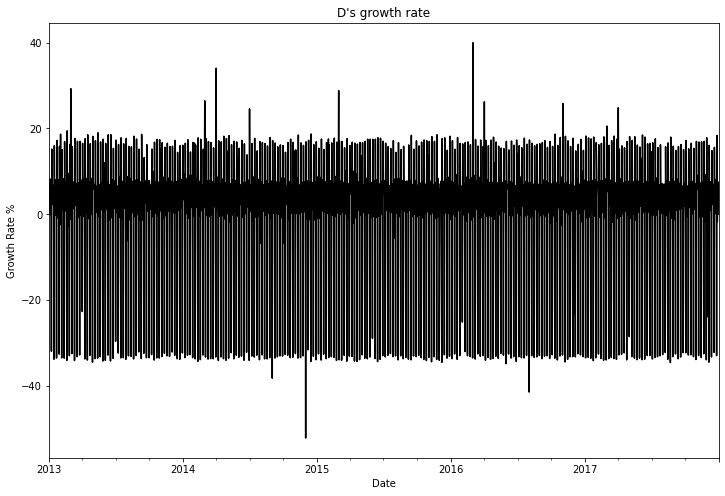

In [ ]:
# Most Profitable day of the dataset
df_day = period_profitable("D", True)

date
2017-07-23    264008
Freq: W-SUN, Name: sales, dtype: int64


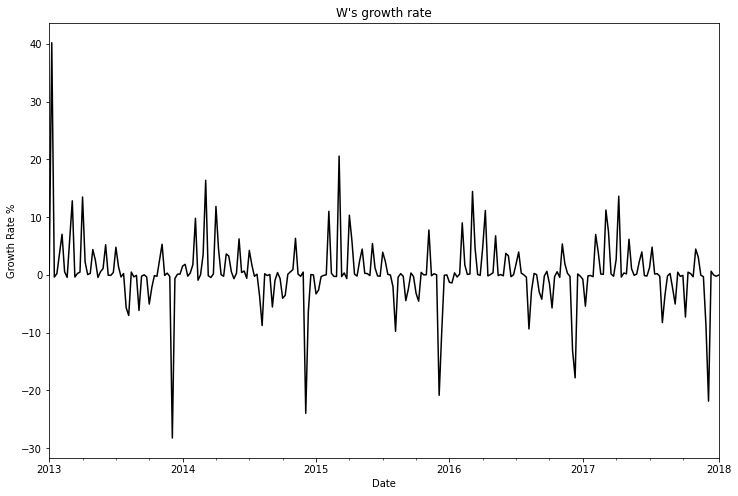

In [ ]:
# Most profitable week of dataset
df_day = period_profitable("W", True)

date
2017-07-31    1178411
Freq: M, Name: sales, dtype: int64


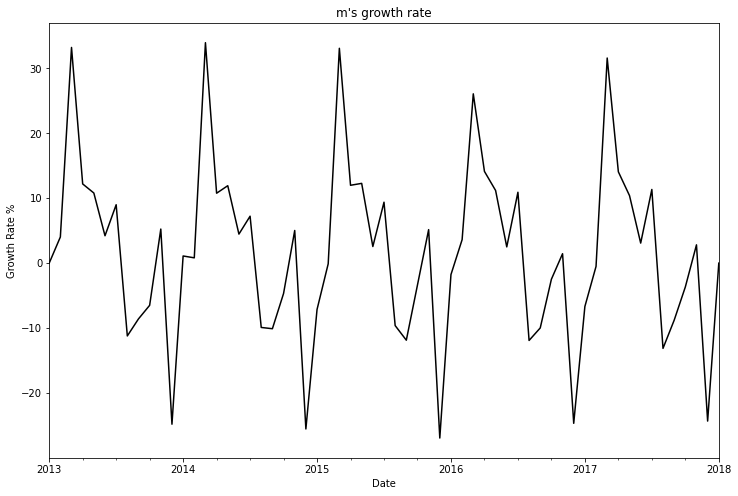

In [ ]:
# Most profitable month of dataset
df_day = period_profitable("m", True)

date
2017-09-30    3135618
Freq: Q-DEC, Name: sales, dtype: int64


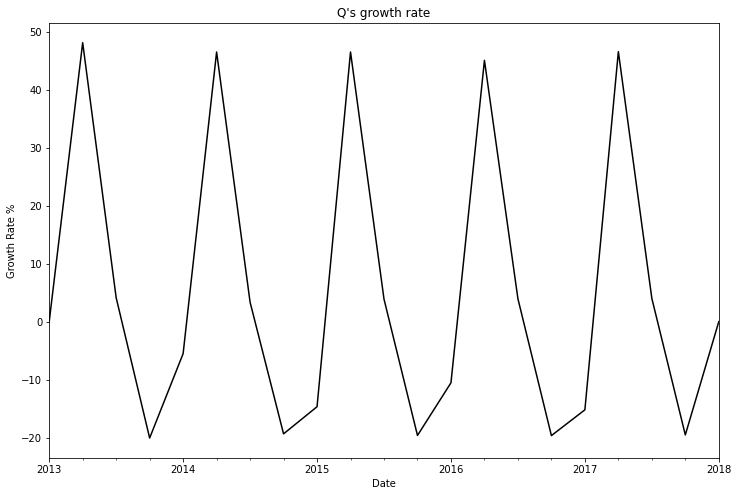

In [ ]:
# Most profitable quater of the dataset
df_quarter = period_profitable("Q" ,True)

### observations:
So as we can see, growth rates compared to previous sales performance are losing the volatility. This implicit in the stabilization of our company sales, predictability of future sales and financial trust.

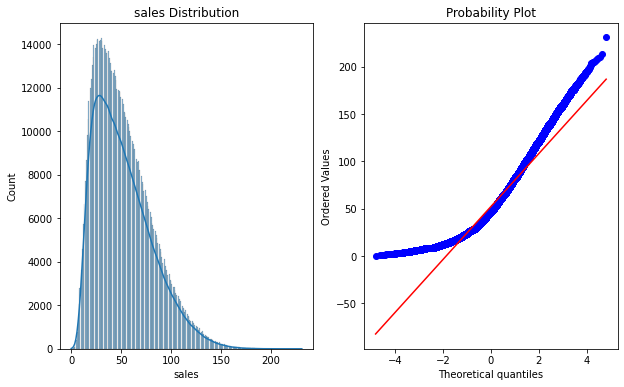

In [ ]:
# Checking the Distribution of the Sales Feature
import scipy.stats as stat
import pylab 

def plot_data(df,feature):
  plt.figure(figsize=(10,6))
  plt.subplot(1,2,1)
  sns.histplot(data=df, x=feature, kde=True).set(title=feature+' Distribution')
  plt.subplot(1,2,2)
  stat.probplot(df[feature],dist='norm',plot=pylab)
  plt.show()

plot_data(df, 'sales')

# Feature Engineering
As we'll be using time series's features for machine learning, we'll should be generating new features to rise machine's success.

In the very first step, we'll be generating features based on datetime variable. This will help us find the seasonality in time series.

In [ ]:
# Taking the copy of the dataframe
new_df = df.copy()

# Generating new columns for model development
def create_date_features(df):
    df['month'] = df.date.dt.month   
    df['week_of_year'] = df.date.dt.weekofyear
    df['day_of_week'] = df.date.dt.dayofweek
    df['year'] = df.date.dt.year
    df["is_wknd"] = df.date.dt.weekday // 4
    df['is_month_start'] = df.date.dt.is_month_start.astype(int)
    df['is_month_end'] = df.date.dt.is_month_end.astype(int)
    df['quarter'] = df['date'].dt.quarter
    return df

new_df = create_date_features(new_df)

In [ ]:
new_df.head()

,date,store,item,sales,month,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,quarter
0,2013-01-01,1,1,13,1,1,1,2013,0,1,0,1
1,2013-01-02,1,1,11,1,1,2,2013,0,0,0,1
2,2013-01-03,1,1,14,1,1,3,2013,0,0,0,1
3,2013-01-04,1,1,13,1,1,4,2013,1,0,0,1
4,2013-01-05,1,1,10,1,1,5,2013,1,0,0,1


In [ ]:
new_df.dtypes

date              datetime64[ns]
store                      int64
item                       int64
sales                      int64
month                      int64
week_of_year               int64
day_of_week                int64
year                       int64
is_wknd                    int64
is_month_start             int64
is_month_end               int64
quarter                    int64
dtype: object

[Text(0.5, 1.0, 'month vs sales')]

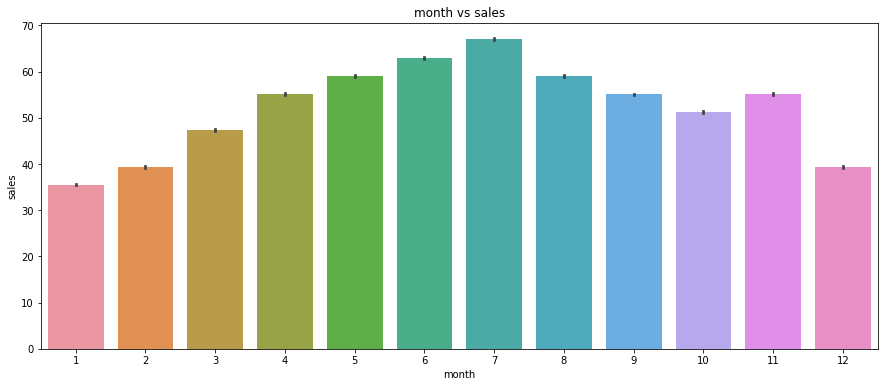

In [ ]:
# plotting the month vs sales
plt.figure(figsize=(15, 6))
sns.barplot(data=new_df, x="month", y="sales").set(title='month vs sales')

### observations:
1.  Here we can clearly see that january to july sales is increases after that it will start decreases.
2.  again november there is a peak over there.  we can see the seasonality also.

[Text(0.5, 1.0, 'week_of_year vs sales')]

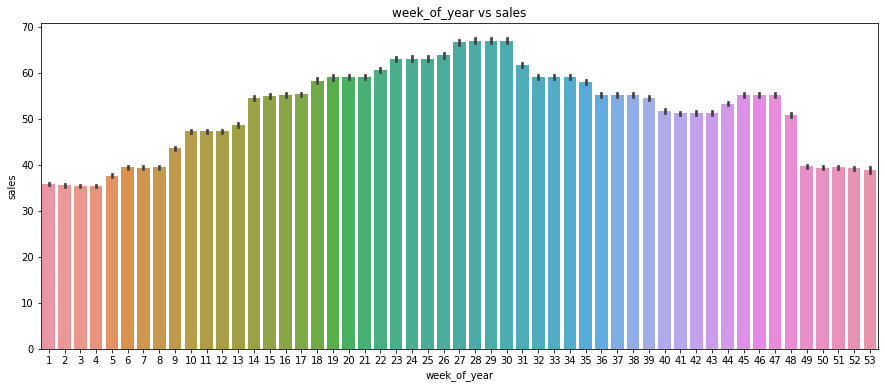

In [ ]:
# plotting the week of the year vs target
plt.figure(figsize=(15, 6))
sns.barplot(data=new_df, x="week_of_year", y="sales").set(title='week_of_year vs sales')

### observations:
1.  above we can see thatn 1 st week to 27 th wee there is increasing trend over there.  after that drecreasing trend then again 43-47 increasing trend over there. after that drecreasing trend

[Text(0.5, 1.0, 'day_of_week vs sales')]

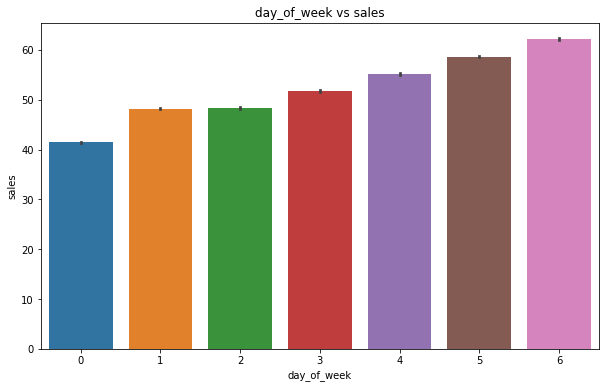

In [ ]:
# plotting the day of the week vs sales
plt.figure(figsize=(10, 6))
sns.barplot(data=new_df, x="day_of_week", y="sales").set(title='day_of_week vs sales')

### observations:
1.  day 1 to day 7 there is a increasing trend over there.

[Text(0.5, 1.0, 'year vs sales')]

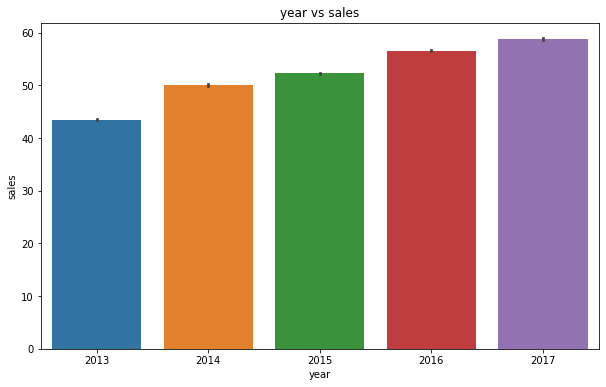

In [ ]:
# plotting the year vs sales
plt.figure(figsize=(10, 6))
sns.barplot(data=new_df, x="year", y="sales").set(title='year vs sales')

### observations:
1. year wise also we can see the increasing trend.

[Text(0.5, 1.0, 'is_wknd vs sales')]

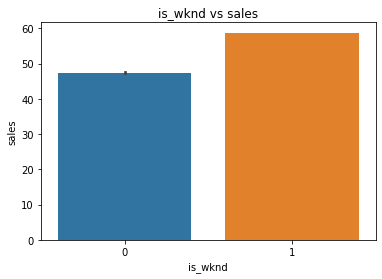

In [ ]:
# plotting the is_wknd vs sales
sns.barplot(data=new_df, x="is_wknd", y="sales").set(title='is_wknd vs sales')

### observations:
1.  in week ends sales was high when compared to week days.

[Text(0.5, 1.0, 'is_month_start vs sales')]

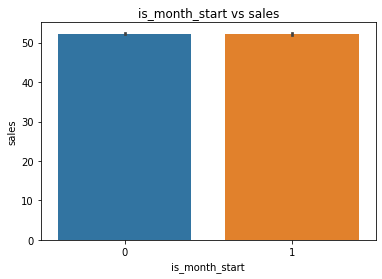

In [ ]:
# plotting the is_month_start vs sales
sns.barplot(data=new_df, x="is_month_start", y="sales").set(title='is_month_start vs sales')

[Text(0.5, 1.0, 'is_month_end vs sales')]

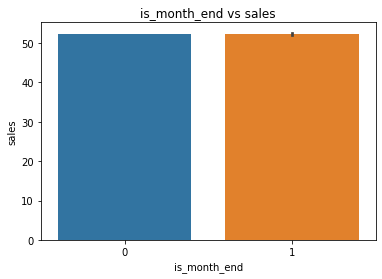

In [ ]:
# plotting the is_month_end vs sales
sns.barplot(data=new_df, x='is_month_end', y='sales').set(title='is_month_end vs sales')

### observations:
1.  There was no difference with respect to month end or month start.  sales is normal.

[Text(0.5, 1.0, 'quarter vs sales')]

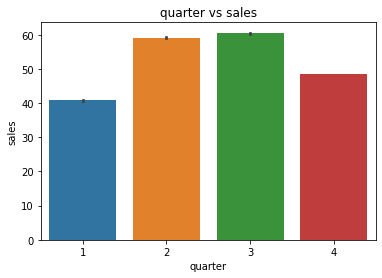

In [ ]:
# plotting the quarter vs sales
sns.barplot(data=new_df, x='quarter', y='sales').set(title='quarter vs sales')

### observations:
1. in quater of the year we can see the seasonlity

In [ ]:
# aggregating the items and printing the sales sum on descending order
items = new_df.groupby(["item"]).agg({  "sales"   : "sum"}).reset_index().sort_values(by='sales',ascending=False)
items.head()

,item,sales
14,15,1607442
27,28,1604713
12,13,1539621
17,18,1538876
24,25,1473334


### observations:
1. item 14 has the highest sales count followed by item27, 12, 17, 24

[Text(0.5, 1.0, 'items vs sales')]

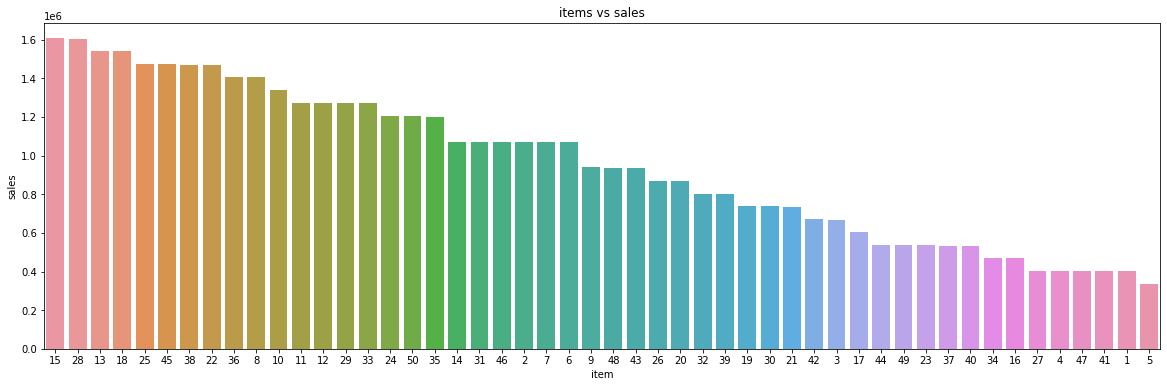

In [ ]:
# plotting the item vs sales
fig, ax = plt.subplots(figsize=(20, 6))
sns.barplot(data=items, x="item", y="sales", order=items.sort_values('sales', ascending=False).item).set(title='items vs sales')

[Text(0.5, 1.0, 'Each items quarterly sales')]

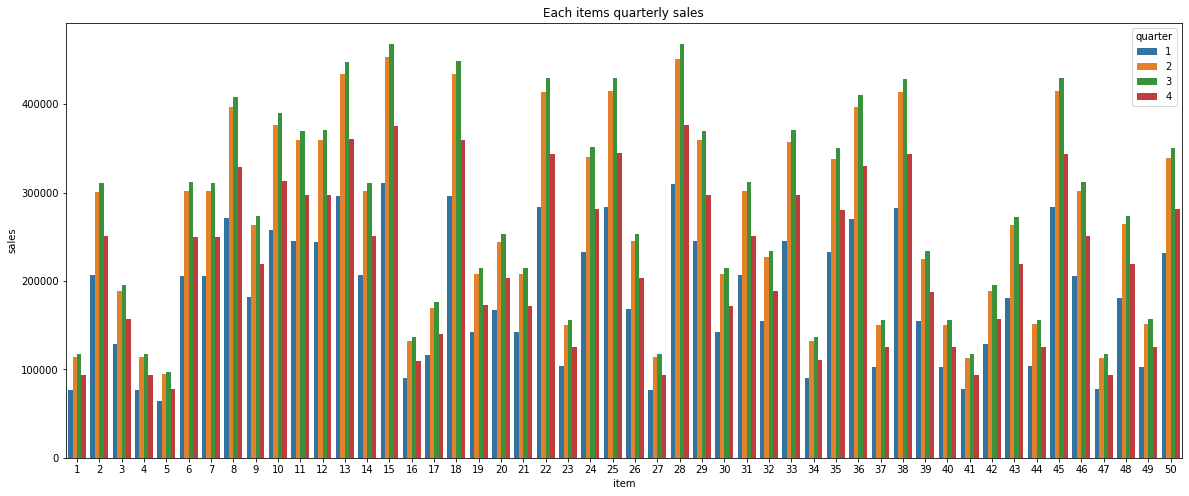

In [ ]:
quarter_item = new_df.groupby(['quarter','item']).agg({  "sales"   : "sum"}).reset_index()

# ploting the quarterly wise each item sales 
plt.figure(figsize=(20, 8))
sns.barplot(data = quarter_item,x = 'item' ,y = 'sales', hue = 'quarter').set(title='Each items quarterly sales')

### observations:
from the above we can clearly see than quarter1, 4 items having the less sales when compared to quarter 2, 3

In [ ]:
# creating the new groupby dataframe series by grouping the item by date wise and aggregating sum of the sales
data_week = df.groupby(['item','date'])['sales'].sum()

In [ ]:
# group by data
data_week 

item  date      
1     2013-01-01    133
      2013-01-02     99
      2013-01-03    127
      2013-01-04    145
      2013-01-05    149
                   ... 
50    2017-12-27    511
      2017-12-28    587
      2017-12-29    596
      2017-12-30    612
      2017-12-31    626
Name: sales, Length: 91300, dtype: int64

In [ ]:
# calculating the sum of sales for each item in 3 month level
quarterly_sales = []
for item in range(1,51):
  ts = pd.Timestamp('2013-01-01')
  while(ts <= pd.Timestamp("2017-10-3")):
    d4 = dict()
    d4['item'] = item
    d4['date'] = ts
    d4['quarterly_sales'] = data_week.loc[item, ts:ts+pd.DateOffset(days = 90)].sum()
    quarterly_sales.append(d4)
    ts +=pd.DateOffset(days = 7)

In [ ]:
# creating a dataframe and adding generated values 
df_week = pd.DataFrame(quarterly_sales)
df_week.head()

,item,date,quarterly_sales
0,1,2013-01-01,12981
1,1,2013-01-08,13542
2,1,2013-01-15,14030
3,1,2013-01-22,14500
4,1,2013-01-29,15003


In [ ]:
df_week['year'] = df_week['date'].dt.year # year column

df_week['day'] = df_week['date'].dt.day # day of the month  column

df_week['quarter'] = df_week['date'].dt.quarter # quarter of the year column

df_week['month'] = df_week['date'].dt.month # month column

In [ ]:
# printing the shape of the new dataframe
df_week.shape

(12450, 7)

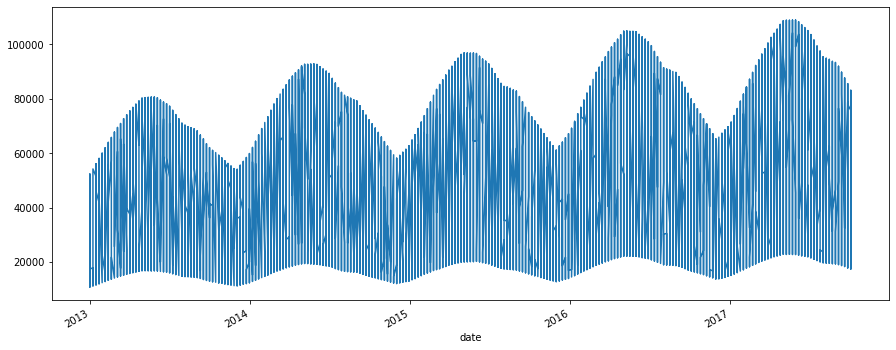

In [ ]:
# checking the trend of the data using line plot
df_week.set_index('date').quarterly_sales.plot(figsize=(15, 6))

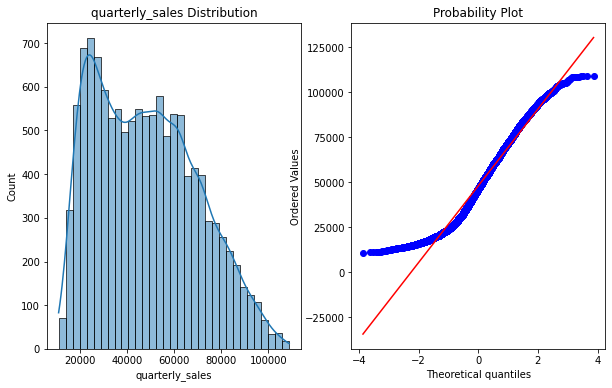

In [ ]:
# plotting the quarterly sales price
plot_data(df_week, 'quarterly_sales')

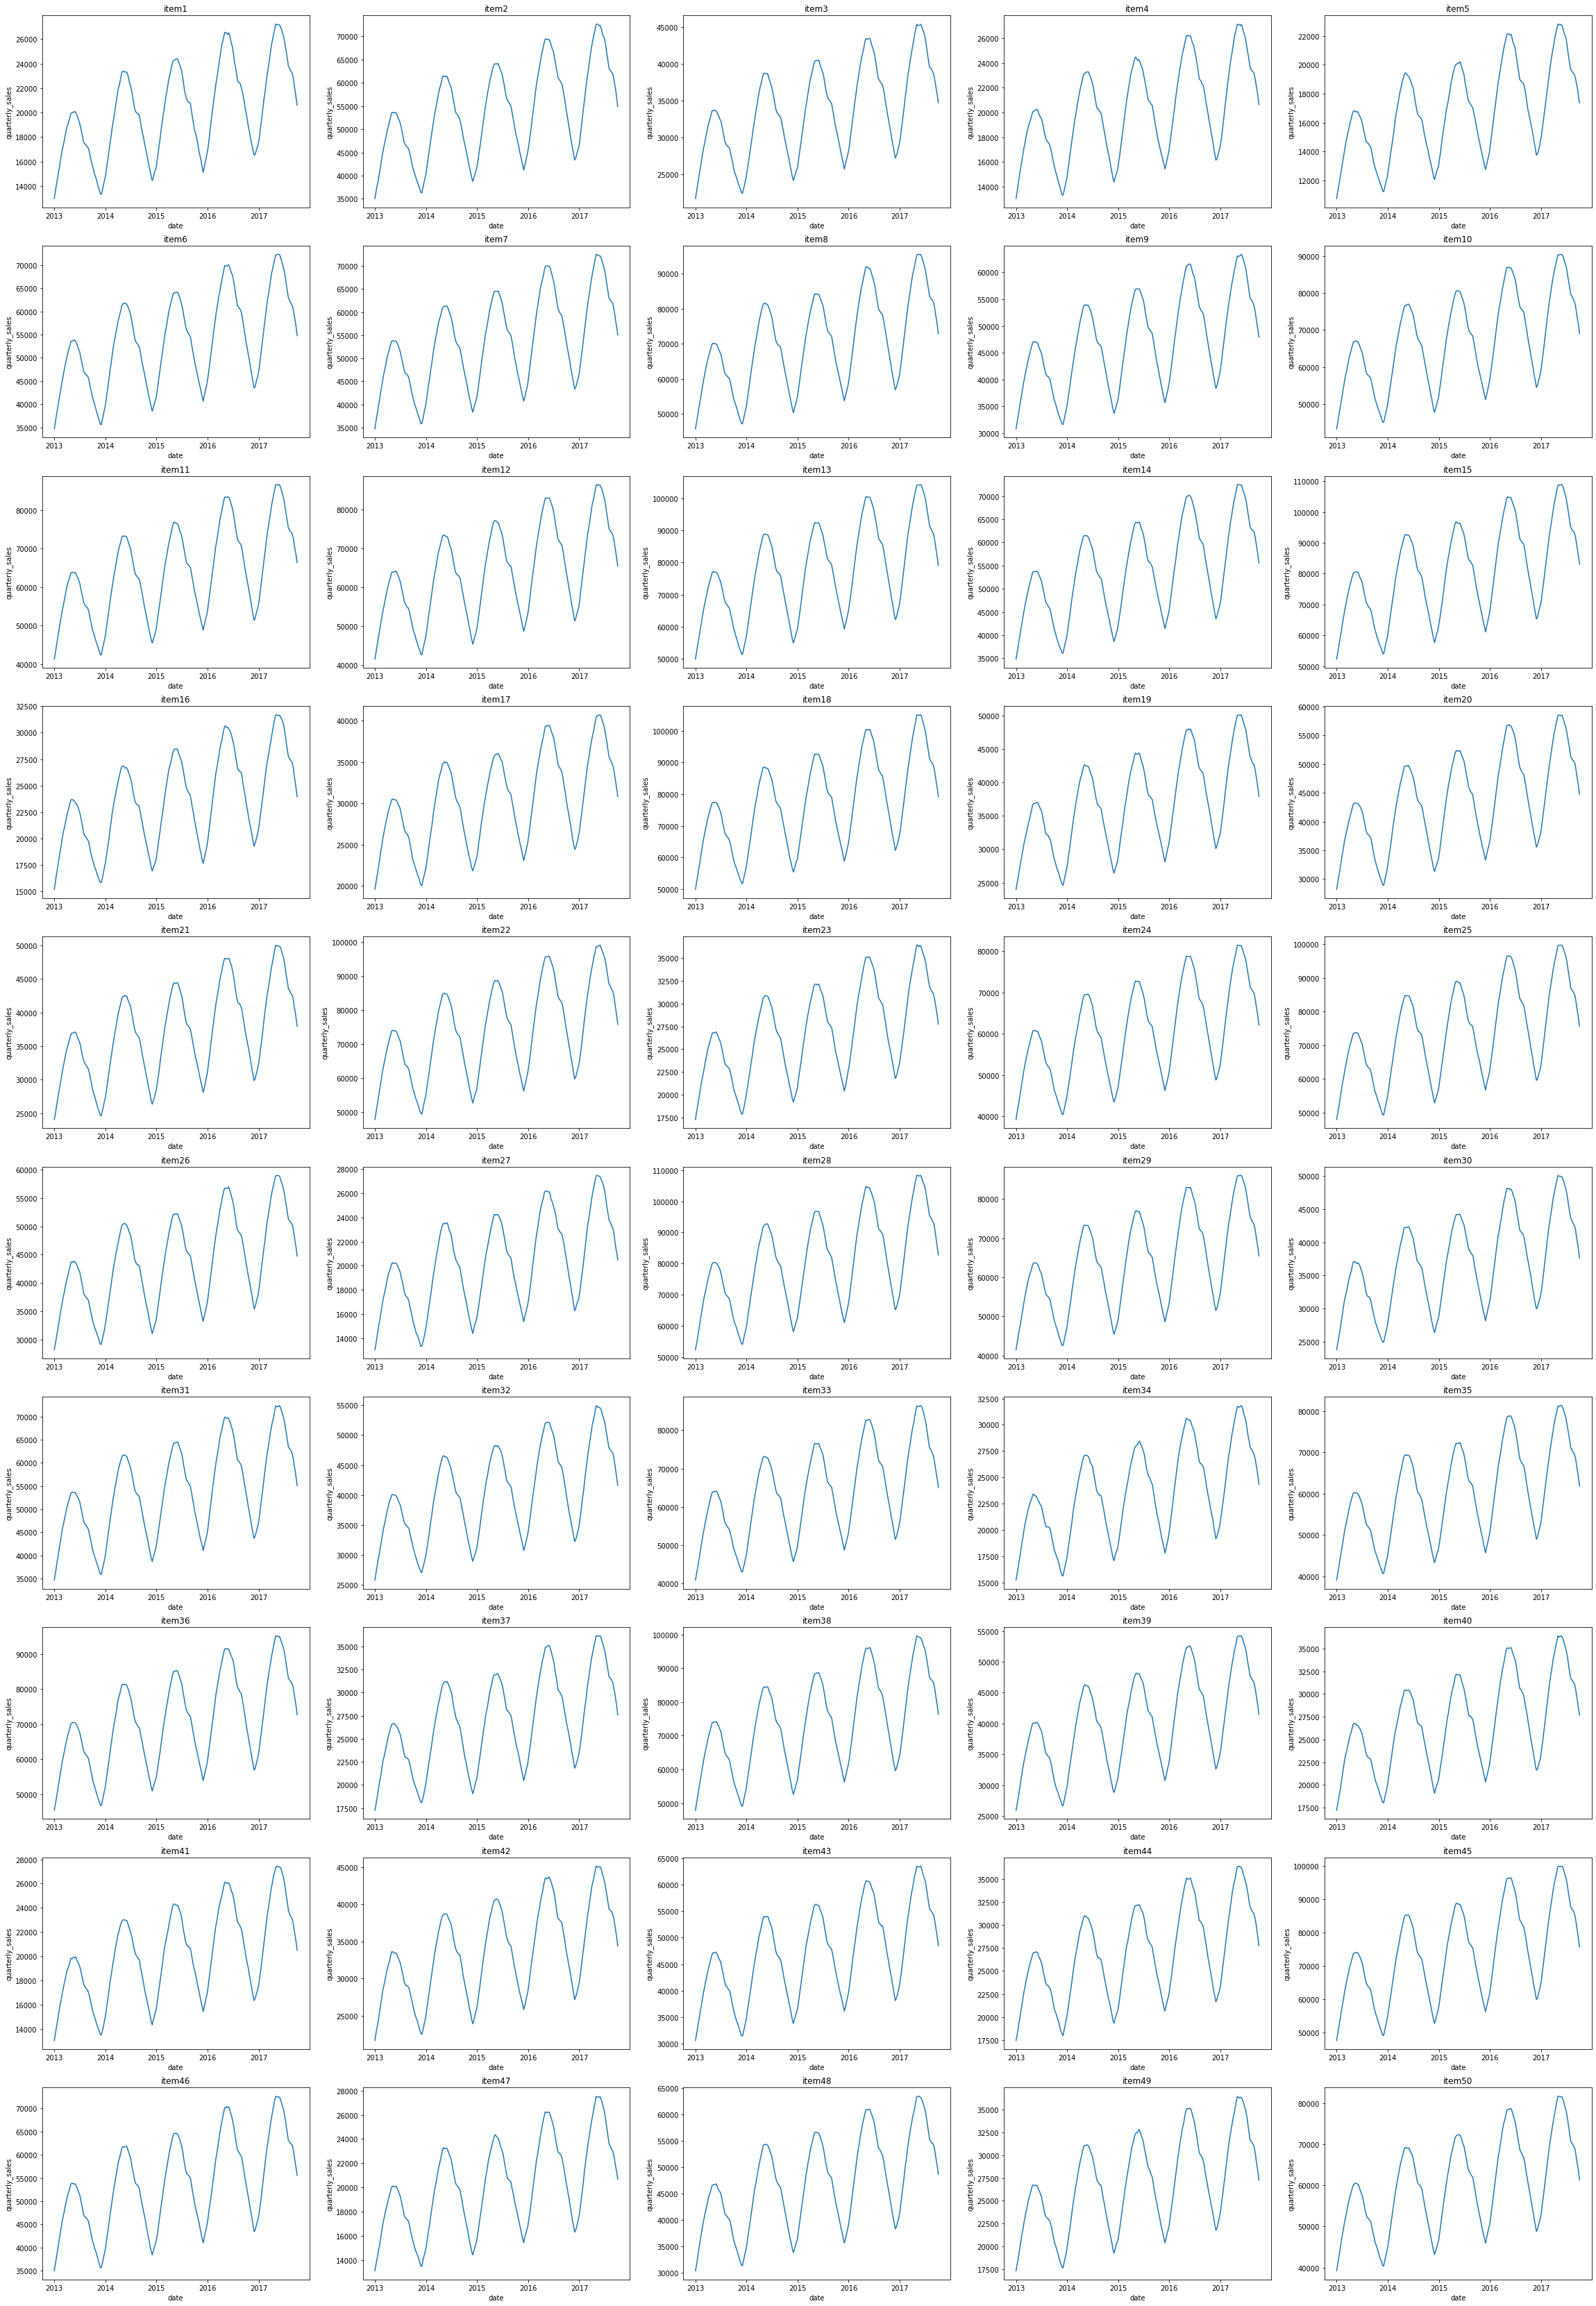

In [ ]:
# plotting the each and every item based on quarterly sales
fig, axes = plt.subplots(10, 5, figsize = (40,60))

for i in range(50):
  sns.lineplot(ax = axes[int(i/5),i%5], data = df_week[df_week['item'] == i+1 ], x = 'date', y = 'quarterly_sales')
  axes[int(i/5),i%5].set_title('item' + str(i+1))

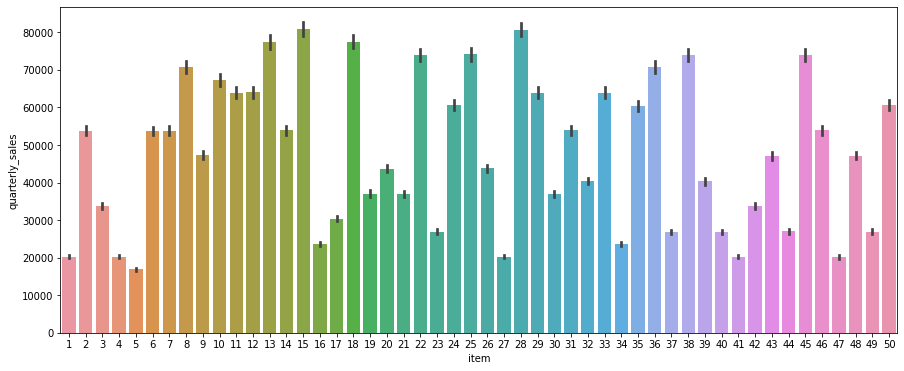

In [ ]:
plt.figure(figsize=(15, 6))
sns.barplot(data=df_week, x='item', y='quarterly_sales')

### observations there is no linear relationship for the items so we can perform one hot encoding for this

# Chumma work

In [ ]:
df_week.head()

,item,date,quarterly_sales,year,day,quarter,month
0,1,2013-01-01,12981,2013,1,1,1
1,1,2013-01-08,13542,2013,8,1,1
2,1,2013-01-15,14030,2013,15,1,1
3,1,2013-01-22,14500,2013,22,1,1
4,1,2013-01-29,15003,2013,29,1,1


# performing one hot encoding for item column

In [ ]:

df_copy = df_week.copy()
df_copy = pd.get_dummies(df_week['item'])


# we cannot perform slicing on numerical column names. pandas doesn't allow as to do that
# pandas provide inbuild function called add_prefix to convert column nmaes to objects
df_copy = df_copy.add_prefix('item_')


df_model = pd.concat([df_week, df_copy], axis=1)
df_model.head()

,item,date,quarterly_sales,year,day,quarter,month,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,item_10,item_11,item_12,item_13,item_14,item_15,item_16,item_17,item_18,item_19,item_20,item_21,item_22,item_23,item_24,item_25,item_26,item_27,item_28,item_29,item_30,item_31,item_32,item_33,item_34,item_35,item_36,item_37,item_38,item_39,item_40,item_41,item_42,item_43,item_44,item_45,item_46,item_47,item_48,item_49,item_50
0,1,2013-01-01,12981,2013,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,2013-01-08,13542,2013,8,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,2013-01-15,14030,2013,15,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,2013-01-22,14500,2013,22,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,2013-01-29,15003,2013,29,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Dropping the unwanted features like dates and item
df_model.drop(['date', 'item'], axis=1, inplace=True)

In [ ]:
# checking the top 2 records after dropping
df_model.head(2)

,quarterly_sales,year,day,quarter,month,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,item_10,item_11,item_12,item_13,item_14,item_15,item_16,item_17,item_18,item_19,item_20,item_21,item_22,item_23,item_24,item_25,item_26,item_27,item_28,item_29,item_30,item_31,item_32,item_33,item_34,item_35,item_36,item_37,item_38,item_39,item_40,item_41,item_42,item_43,item_44,item_45,item_46,item_47,item_48,item_49,item_50
0,12981,2013,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,13542,2013,8,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Checking the datatypes of the final dataframe
df_model.dtypes

quarterly_sales    int64
year               int64
day                int64
quarter            int64
month              int64
item_1             uint8
item_2             uint8
item_3             uint8
item_4             uint8
item_5             uint8
item_6             uint8
item_7             uint8
item_8             uint8
item_9             uint8
item_10            uint8
item_11            uint8
item_12            uint8
item_13            uint8
item_14            uint8
item_15            uint8
item_16            uint8
item_17            uint8
item_18            uint8
item_19            uint8
item_20            uint8
item_21            uint8
item_22            uint8
item_23            uint8
item_24            uint8
item_25            uint8
item_26            uint8
item_27            uint8
item_28            uint8
item_29            uint8
item_30            uint8
item_31            uint8
item_32            uint8
item_33            uint8
item_34            uint8
item_35            uint8


In [ ]:
# slicing the dataset into train, validation, and test based on year feature
train = df_model.loc[(df_model["year"] <=2015)]
val = df_model.loc[(df_model["year"] == 2016)]
test = df_model.loc[(df_model["year"] == 2017)]

In [ ]:
# spliting the data into x_train and y_train like that 
X_train = train.drop(columns = ['quarterly_sales'])
Y_train = train['quarterly_sales']

val_train = val.drop(columns = ['quarterly_sales'])
val_test = val['quarterly_sales']

x_test = test.drop(columns = ['quarterly_sales'])
y_test = test['quarterly_sales']

In [ ]:
# checking the shape of the train and test data
print('shape of X_train : {}'.format(X_train.shape))
print('shape of Y_train : {}'.format(Y_train.shape))
print()
print('shape of val_train : {}'.format(val_train.shape))
print('shape of val_test : {}'.format(val_test.shape))
print()
print('shape of X_test : {}'.format(x_test.shape))
print('shape of y_test : {}'.format(y_test.shape))

shape of X_train : (7850, 54)
shape of Y_train : (7850,)

shape of val_train : (2600, 54)
shape of val_test : (2600,)

shape of X_test : (2000, 54)
shape of y_test : (2000,)


# MODELLING

In [ ]:
#hyper parameters for lightGBM
lgbm_params ={ "num_leaves": [10,15,20,30],
              "learning_rate": [0.1, 0.05, 0.02],
              "colsample_bytree":[0.5, 0.8, 1.0],
              "max_depth": [5, 7, 10, 20],
             }

In [ ]:
# fitting the model
model = lgb.LGBMRegressor()
tscv = TimeSeriesSplit(n_splits=3)
rsearch2 = RandomizedSearchCV(model, lgbm_params, cv=tscv, verbose = True, n_jobs = -1).fit( X_train, Y_train )

Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [ ]:
# Best Parameters
rsearch2.best_params_

{'colsample_bytree': 0.8,
 'learning_rate': 0.05,
 'max_depth': 20,
 'num_leaves': 20}

In [ ]:
# Using the above best parameters of randomized search cv we can give to lightGBM model
parameters = {'metric': 'root_mean_squared_error',
              'boosting': 'gbdt',
              'num_leaves': 20,
              'feature_fraction': 0.5,
              'bagging_fraction': 0.5,
              'bagging_freq': 20,
              'max_depth': 20,
              'learning_rate': 0.05,
              'verbose': -1,
              'colsample_bytree':0.8
             }

In [ ]:
# loading the dataset into model for training
lgbtrain = lgb.Dataset(data=X_train, label=Y_train)

# loading the validation dataset
lgbval = lgb.Dataset(data=val_train, label=val_test)

In [ ]:
# training the model with train and validation dataset with parameter
# using the number of bossting rounds 1000 and stop at maximum 50% more in  early stopping round
model_lgbm = lgb.train(parameters,
                            lgbtrain,
                            valid_sets=lgbval,
                            num_boost_round=2000,
                            early_stopping_rounds=50)

[1]	valid_0's rmse: 23281.2
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 22941.9
[3]	valid_0's rmse: 22654.1
[4]	valid_0's rmse: 22288.3
[5]	valid_0's rmse: 21865.2
[6]	valid_0's rmse: 21459.6
[7]	valid_0's rmse: 21168.9
[8]	valid_0's rmse: 20860.9
[9]	valid_0's rmse: 20484.7
[10]	valid_0's rmse: 20162.1
[11]	valid_0's rmse: 19828.6
[12]	valid_0's rmse: 19492.2
[13]	valid_0's rmse: 19238.3
[14]	valid_0's rmse: 18953.2
[15]	valid_0's rmse: 18645.6
[16]	valid_0's rmse: 18393.5
[17]	valid_0's rmse: 18136.5
[18]	valid_0's rmse: 17859.2
[19]	valid_0's rmse: 17595.9
[20]	valid_0's rmse: 17396.5
[21]	valid_0's rmse: 17093
[22]	valid_0's rmse: 16828.7
[23]	valid_0's rmse: 16571.1
[24]	valid_0's rmse: 16330.5
[25]	valid_0's rmse: 16133.5
[26]	valid_0's rmse: 15933.5
[27]	valid_0's rmse: 15707.3
[28]	valid_0's rmse: 15498.6
[29]	valid_0's rmse: 15300.1
[30]	valid_0's rmse: 15071.3
[31]	valid_0's rmse: 14846.1
[32]	valid_0's rmse: 14647
[33]	valid_0's rmse: 14

In [ ]:
# predicting the values for training and validtion
y_train_pred = model_lgbm.predict(X_train) 
y_valid_pred = model_lgbm.predict(val_train)

In [ ]:
# printing the accuacy using the r2_score 
print("r2_score Train: {:.4f}\nr2_score Valid: {:.4f}".format(r2_score(Y_train, y_train_pred),
                                                    r2_score(val_test, y_valid_pred)))

r2_score Train: 0.9980
r2_score Valid: 0.9596


# Important Features

Text(0, 0.5, 'Feature Importance Score')

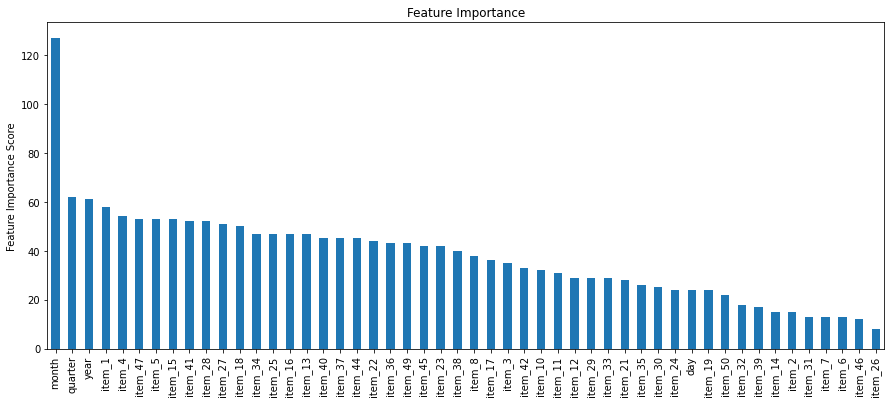

In [ ]:
# mapping the feature importance
predictors = [x for x in X_train.columns]
feat_imp = pd.Series(rsearch2.best_estimator_.feature_importances_, predictors).sort_values(ascending=False)
feat_imp = feat_imp[0:50]
plt.rcParams['figure.figsize'] = 15, 6
feat_imp.plot(kind='bar', title='Feature Importance')
plt.ylabel('Feature Importance Score')

# Final Model

In [ ]:
#predicting for the test data 
predict = model_lgbm.predict(x_test)

In [ ]:
# predictions
predict

array([14046.32738931, 14746.08832025, 16405.9925687 , ...,
       58598.52103294, 58065.23466282, 54463.41246369])

In [ ]:
# Checking the R2 value
r2_score(y_test, predict)

0.9124284815153701

In [ ]:
df1 = test

In [ ]:
# we are converting this values from float to int as sales are in int datatype
p = predict.astype(int) 

# appending the values to dataframe
df1['predict_sales'] = p 

In [ ]:
# printing the dataframe
df1

,quarterly_sales,year,day,quarter,month,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,item_10,item_11,item_12,item_13,item_14,item_15,item_16,item_17,item_18,item_19,item_20,item_21,item_22,item_23,item_24,item_25,item_26,item_27,item_28,item_29,item_30,item_31,item_32,item_33,item_34,item_35,item_36,item_37,item_38,item_39,item_40,item_41,item_42,item_43,item_44,item_45,item_46,item_47,item_48,item_49,item_50,predict_sales
209,17715,2017,3,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14046
210,18366,2017,10,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14746
211,18990,2017,17,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16405
212,19656,2017,24,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17271
213,20344,2017,31,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,18236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12445,68007,2017,5,3,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,60662
12446,66445,2017,12,3,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,59692
12447,64902,2017,19,3,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,58598
12448,63360,2017,26,3,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,58065


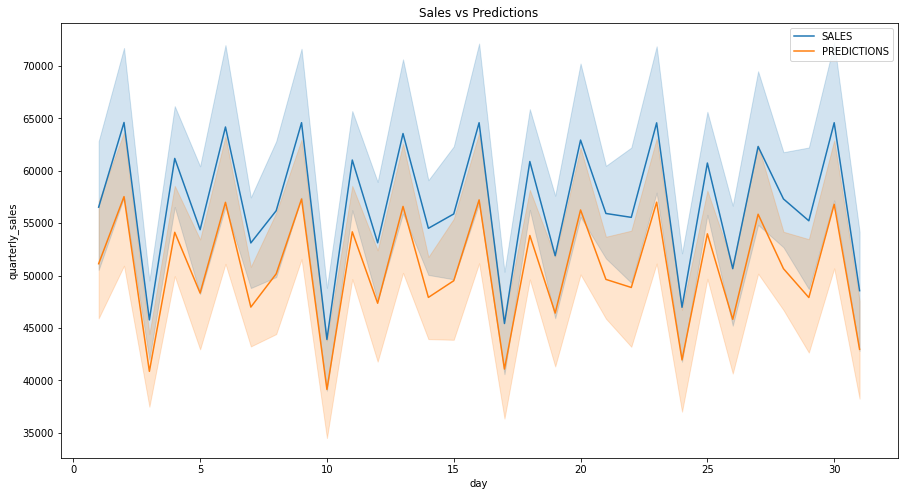

In [ ]:
plt.figure(figsize=(15, 8))
plt.title("Sales vs Predictions")

sns.lineplot( x='day', y='quarterly_sales', data=df1, label='SALES' )
sns.lineplot( x='day', y='predict_sales', data=df1, label='PREDICTIONS' )

plt.show()